# Access CESM2 LENS data from NCAR's Geoscience Data Exchange (GDEX) and compute GMST
## Table of Contents
- [Section 1: Introduction](#Section-1:-Introduction) 
- [Section 2: Select Dask Cluster](#Section-2:-Select-Dask-Cluster) 
- [Section 3: Data Loading](#Section-3:-Data-Loading) 
- [Section 4: Data Analysis](#Section-4:-Data-Analysis)  

## Section 1: Introduction
- Python package imports and useful function definitions

In [1]:
# Display output of plots directly in Notebook
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import intake
import numpy as np
import xarray as xr
import nc_time_axis

In [2]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [5]:
lustre_scratch   = "/lustre/desc1/scratch/harshah"
#
catalog_url = 'https://data-osdf.gdex.ucar.edu/ncar-gdex/d010092/catalogs/d010092-osdf-zarr.json' 
# catalog_url = 'https://stratus.gdex.ucar.edu/d010092/catalogs/d010092-https-zarr.json' #NCAR's Object store

In [4]:
# GMST function ###
# calculate global means
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time','member_id'}
    return (ds * weight).mean(other_dims)

## Section 2: Select Dask Cluster
- Setting up a dask cluster. You will need to choose the type of cluster based on your use case.
- The default will be LocalCluster as that can run on any system.
- If running on NCAR's HPC i.e, Casper with a PBS Scheduler, set USE_PBS_SCHEDULER to True. Otherwise, set to False.

In [5]:
USE_PBS_SCHEDULER = True

If running on Jupyter server with Dask Gateway configured, set to True. Otherwise, set to False.

In [6]:
USE_DASK_GATEWAY = False

#### Python function for a PBS cluster

In [7]:
# Create a PBS cluster object
def get_pbs_cluster():
    """ Create cluster through dask_jobqueue.   
    """
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(
        job_name = 'dask-osdf-25',
        cores = 1,
        memory = '4GiB',
        processes = 1,
        local_directory = lustre_scratch + '/dask/spill',
        log_directory = lustre_scratch + '/dask/logs/',
        resource_spec = 'select=1:ncpus=1:mem=4GB',
        queue = 'casper',
        walltime = '3:00:00',
        #interface = 'ib0'
        interface = 'ext'
    )
    return cluster

#### Python function for a Gateway Cluster

In [8]:
def get_gateway_cluster():
    """ Create cluster through dask_gateway
    """
    from dask_gateway import Gateway

    gateway = Gateway()
    cluster = gateway.new_cluster()
    cluster.adapt(minimum=2, maximum=4)
    return cluster

#### Python function for a Local Cluster

In [9]:
def get_local_cluster():
    """ Create cluster using the Jupyter server's resources
    """
    from distributed import LocalCluster, performance_report
    cluster = LocalCluster()    

    return cluster

#### Python logic to select the Dask Cluster type
- This uses True/False boolean logic based on the variables set in the previous cells

In [10]:
# Obtain dask cluster in one of three ways

if USE_PBS_SCHEDULER:
    cluster = get_pbs_cluster()
elif USE_DASK_GATEWAY:
    cluster = get_gateway_cluster()
else:
    cluster = get_local_cluster()

# Connect to cluster
from distributed import Client
client = Client(cluster)

In [11]:
cluster.scale(4)
client.wait_for_workers(4)
cluster

PBSCluster(6b8b3bd0, 'tcp://128.117.208.96:33027', workers=4, threads=4, memory=16.00 GiB)

## Section 3: Data Loading
- Load CESM2 LENS zarr data from GDEX using an intake-ESM catalog
- For more details regarding the dataset. See, https://gdex.ucar.edu/datasets/d010092/#

In [6]:
# Open collection description file using intake
col   = intake.open_esm_datastore(catalog_url)
col

,unique
Unnamed: 0,322
variable,53
long_name,51
component,4
experiment,2
forcing_variant,2
frequency,3
vertical_levels,3
spatial_domain,3
units,20


In [7]:
cesm_temp = col.search(variable ='TREFHT', frequency ='monthly')
cesm_temp

,unique
Unnamed: 0,4
variable,1
long_name,1
component,1
experiment,2
forcing_variant,2
frequency,1
vertical_levels,1
spatial_domain,1
units,1


In [8]:
cesm_temp.df['path'].values

array(['https://stratus.gdex.ucar.edu/d010092/atm/monthly/cesm2LE-historical-cmip6-TREFHT.zarr',
       'https://stratus.gdex.ucar.edu/d010092/atm/monthly/cesm2LE-historical-smbb-TREFHT.zarr',
       'https://stratus.gdex.ucar.edu/d010092/atm/monthly/cesm2LE-ssp370-cmip6-TREFHT.zarr',
       'https://stratus.gdex.ucar.edu/d010092/atm/monthly/cesm2LE-ssp370-smbb-TREFHT.zarr'],
      dtype=object)

In [15]:
dsets_cesm = cesm_temp.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


In [16]:
dsets_cesm.keys()

dict_keys(['atm.historical.monthly.cmip6', 'atm.ssp370.monthly.cmip6', 'atm.historical.monthly.smbb', 'atm.ssp370.monthly.smbb'])

In [17]:
historical_cmip6 = dsets_cesm['atm.historical.monthly.cmip6']
future_cmip6     = dsets_cesm['atm.ssp370.monthly.cmip6']

In [18]:
future_cmip6 

<xarray.Dataset> Size: 11GB
Dimensions:    (member_id: 50, time: 1032, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 8kB 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
    time_bnds  (time, nbnd) object 17kB dask.array<chunksize=(1032, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    TREFHT     (member_id, time, lat, lon) float32 11GB dask.array<chunksize=(1, 600, 192, 288), meta=np.ndarray>
Attributes: (12/23)
    Conventions:                       CF-1.0
    host:                              mom1
    logname:                           sunseon
    model_doi_url:                     https://doi.org/10.5065/D67H1H0V
    source:                            CAM
    time_period_freq:                  month_1
    ...                                ...
    intake_esm_attrs:units:            K
    intake_esm_attrs:start_time:       2015-01-16 12:00:00
    intake_esm_attrs:end_time:         2100-12-16 12:00:00
    intake_esm_attrs:path:             https://osdf-data.gdex.ucar.edu/ncar-g...
    intake_esm_attrs:_data_format_:    zarr
    intake_esm_dataset_key:            atm.ssp370.monthly.cmip6

### Make a quick plot to check data transfer

CPU times: user 216 ms, sys: 18.6 ms, total: 234 ms
Wall time: 2.44 s


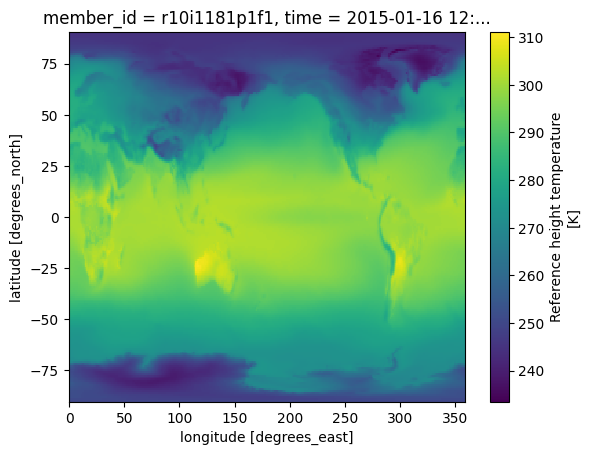

In [19]:
%%time
future_cmip6.TREFHT.isel(member_id=0,time=0).plot()

## Section 4: Data Analysis
- Perform the Global Mean Surface Temperature computation

### Merge datasets and compute Global Mean surrface temperature anomaly
- Warning! This section takes about a min to run!
- Config: 3 dask workers with 8GiB memory.

In [20]:
merge_ds_cmip6 = xr.concat([historical_cmip6, future_cmip6], dim='time')
# merge_ds_cmip6 = merge_ds_cmip6.dropna(dim='member_id')
merge_ds_cmip6 = merge_ds_cmip6.TREFHT
merge_ds_cmip6

<xarray.DataArray 'TREFHT' (member_id: 50, time: 3012, lat: 192, lon: 288)> Size: 33GB
dask.array<concatenate, shape=(50, 3012, 192, 288), dtype=float32, chunksize=(1, 600, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 24kB 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
Attributes:
    cell_methods:  time: mean
    long_name:     Reference height temperature
    units:         K

#### Compute (spatially weighted) Global Mean

In [21]:
ds_cmip6_annual = merge_ds_cmip6.resample(time='AS').mean()
ds_cmip6_annual

<xarray.DataArray 'TREFHT' (member_id: 50, time: 251, lat: 192, lon: 288)> Size: 3GB
dask.array<transpose, shape=(50, 251, 192, 288), dtype=float32, chunksize=(1, 50, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 2kB 1850-01-01 00:00:00 ... 2100-01-01 00:00:00
Attributes:
    cell_methods:  time: mean
    long_name:     Reference height temperature
    units:         K

In [22]:
%%time
gmst_cmip6 = global_mean(ds_cmip6_annual)
gmst_cmip6 = gmst_cmip6.rename('gmst')
gmst_cmip6

CPU times: user 533 ms, sys: 25.2 ms, total: 559 ms
Wall time: 890 ms


<xarray.DataArray 'gmst' (member_id: 50, time: 251)> Size: 100kB
dask.array<mean_agg-aggregate, shape=(50, 251), dtype=float64, chunksize=(1, 50), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 2kB 1850-01-01 00:00:00 ... 2100-01-01 00:00:00

### Compute anomaly and plot

In [23]:
gmst_cmip6_ano = gmst_cmip6 - gmst_cmip6.mean()
gmst_cmip6_ano

<xarray.DataArray 'gmst' (member_id: 50, time: 251)> Size: 100kB
dask.array<sub, shape=(50, 251), dtype=float64, chunksize=(1, 50), chunktype=numpy.ndarray>
Coordinates:
  * member_id  (member_id) <U12 2kB 'r10i1181p1f1' ... 'r9i1301p1f1'
  * time       (time) object 2kB 1850-01-01 00:00:00 ... 2100-01-01 00:00:00

In [24]:
gmst_cmip6_ano = gmst_cmip6_ano.compute()

CPU times: user 25.5 ms, sys: 0 ns, total: 25.5 ms
Wall time: 28.4 ms


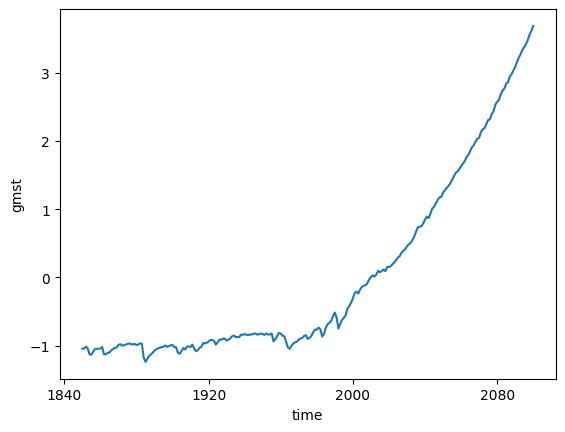

In [25]:
%%time
gmst_cmip6_ano.mean(dim='member_id').plot()

In [26]:
cluster.close()